# Simple multiclass classification on the full MNIST dataset
Includes naive test using pixel average and a simple neural network, using Pytorch and fastai

In [1]:
! pip install -Uqq fastai
from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

### Download data

In [2]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

path.ls()

(#2) [Path('testing'),Path('training')]

In [3]:
print((path/'training').ls(), (path/'testing').ls())

[Path('training/5'), Path('training/6'), Path('training/4'), Path('training/1'), Path('training/9'), Path('training/7'), Path('training/3'), Path('training/2'), Path('training/8'), Path('training/0')] [Path('testing/5'), Path('testing/6'), Path('testing/4'), Path('testing/1'), Path('testing/9'), Path('testing/7'), Path('testing/3'), Path('testing/2'), Path('testing/8'), Path('testing/0')]


In [4]:
train_paths = [(path/'training'/str(n)).ls().sorted() for n in range(10)]

train_paths[2]

(#5958) [Path('training/2/10009.png'),Path('training/2/10016.png'),Path('training/2/10024.png'),Path('training/2/10029.png'),Path('training/2/10072.png'),Path('training/2/10073.png'),Path('training/2/10075.png'),Path('training/2/10078.png'),Path('training/2/10081.png'),Path('training/2/10082.png')...]

In [5]:
Image.open(train_paths[8][42])

### Create tensors for training images

In [6]:
train_tensors = [[tensor(Image.open(o)) for o in n_list] for n_list in train_paths]

train_tensors[3][0].shape

torch.Size([28, 28])

Stack images of the same number to use broadcasting, but keep groups of images in a list because each group has a different length

In [7]:
train_stacked = [torch.stack(n_list).float()/255 for n_list in train_tensors]

train_stacked[1].shape

torch.Size([6742, 28, 28])

## Basic classification based on pixel average
Pixel averages for each number

<Axes: >

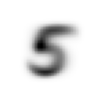

In [8]:
means = [stack.mean(0) for stack in train_stacked]

show_image(means[5])

Distance definition

In [9]:
def mnist_dist(a,b):
    return (a - b).abs().mean((-1, -2))

mnist_dist(means[5], train_stacked[5])

tensor([0.1334, 0.1307, 0.1357,  ..., 0.1342, 0.1350, 0.1338])

Classify an image by selecting the minimum distance from the 10 averages

In [10]:
def classify(x):
    distances = [mnist_dist(x, m) for m in means]
    stacked_distances = torch.stack(distances)
    min_values, min_indices = torch.min(stacked_distances, dim=0)
    return min_indices

print([classify(train_stacked[n][42]).item() for n in range(10)])
print([classify(train_stacked[n][47]).item() for n in range(10)])
print(classify(train_stacked[5]))
print(classify(train_stacked[9]))

[0, 1, 2, 3, 4, 6, 6, 7, 1, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tensor([5, 1, 5,  ..., 1, 5, 1])
tensor([9, 9, 9,  ..., 9, 7, 9])


Define accuracy as the fraction of images that are correctly classified

In [11]:
def accuracy(stacked_tensors):
    accuracies = []
    for n in range(10):
        deviations = (classify(stacked_tensors[n]) - n).abs()
        ones = torch.ones_like(deviations)
        one_if_wrong = torch.minimum(deviations, ones).float()
        acc = (1 - one_if_wrong).mean()
        accuracies.append(acc)
    return sum(accuracies) / 10

The accuracy on the training set is 64%

In [12]:
accuracy(train_stacked)

tensor(0.6429)

The accuracy on the test set is 66%

In [13]:
test_paths = [(path/'testing'/str(n)).ls().sorted() for n in range(10)]
test_tensors = [[tensor(Image.open(o)) for o in n_list] for n_list in test_paths]
test_stacked = [torch.stack(n_list).float()/255 for n_list in test_tensors]

accuracy(test_stacked)

tensor(0.6610)

## Classification with a neural net
### Create training and testing datasets

In [14]:
x_train = torch.cat(train_stacked).view(-1, 28*28)
y_train = tensor([n for n, n_list in enumerate(train_stacked) for _ in range(len(n_list))]).unsqueeze(1)
train_dset = list(zip(x_train, y_train))

x_test = torch.cat(test_stacked).view(-1, 28*28)
y_test = tensor([n for n, n_list in enumerate(test_stacked) for _ in range(len(n_list))]).unsqueeze(1)
test_dset = list(zip(x_test, y_test))

x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([60000, 784]),
 torch.Size([60000, 1]),
 torch.Size([10000, 784]),
 torch.Size([10000, 1]))

### Define DataLoaders, network, loss function and accuracy function

In [15]:
train_dl = DataLoader(train_dset, batch_size=256, shuffle=True)
test_dl = DataLoader(test_dset, batch_size=256, shuffle=True)
dls = DataLoaders(train_dl, test_dl)

simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,10)
)


def mnist_loss(preds, targets):
    # normalize predictions
    norm_preds = F.softmax(preds, dim=1)
    
    # create compatible target labels
    t_targets = torch.zeros_like(norm_preds).float()
    t_targets.scatter_(1, targets, 1.) # set 1 at index corresponding to the label
    
    return (norm_preds - t_targets).abs().mean()
    
    
def batch_accuracy(preds, targets):
    number_preds = preds.argmax(dim=1).unsqueeze(1)
    return (number_preds == targets).float().mean()

In [16]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(50, 1.)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.097111,0.080569,0.650600,00:01
1,0.071842,0.070306,0.667600,00:01
2,0.068163,0.068179,0.671800,00:01
3,0.067030,0.067276,0.673600,00:01
4,0.066326,0.066613,0.675600,00:01
5,0.065537,0.066141,0.677600,00:01
6,0.064641,0.065812,0.678700,00:01
7,0.064977,0.065602,0.678600,00:01
8,0.062138,0.060766,0.711800,00:01
9,0.055814,0.055297,0.736300,00:01


Deeper network

In [17]:
net2 = nn.Sequential(nn.Linear(28*28, 80),
                     nn.ReLU(),
                     nn.Linear(80,50),
                     nn.ReLU(),
                     nn.Linear(50,30),
                     nn.ReLU(),
                     nn.Linear(30,10),)

In [18]:
learn2 = Learner(dls, net2, opt_func=SGD,
                 loss_func=mnist_loss, metrics=batch_accuracy)

learn2.fit(100, 1.)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.178941,0.178220,0.319900,00:01
1,0.110927,0.091891,0.565900,00:01
2,0.073997,0.072796,0.646500,00:01
3,0.069922,0.070686,0.652400,00:01
4,0.068444,0.070011,0.655900,00:01
5,0.068716,0.068693,0.661400,00:01
6,0.066529,0.067808,0.665700,00:01
7,0.067051,0.066637,0.670300,00:01
8,0.065670,0.066489,0.670900,00:01
9,0.065674,0.065487,0.675900,00:01
